# Introduction to Survival Analysis with scikit-survival

**scikit-survival** is a Python module for [survival analysis](https://en.wikipedia.org/wiki/Survival_analysis) built on top of [scikit-learn](http://scikit-learn.org/). It allows doing survival analysis while utilizing the power of scikit-learn, e.g., for pre-processing or doing cross-validation.

scikit-survival是一个基于scikit-learn的Python生存分析模块。它允许利用scikit-learn的能力进行生存分析，例如，进行预处理或交叉验证。

## Table of Contents

1. [What is Survival Analysis?](#What-is-Survival-Analysis?)
2. [The Veterans' Administration Lung Cancer Trial](#The-Veterans%27-Administration-Lung-Cancer-Trial)
3. [Survival Data](#Survival-Data)
4. [The Survival Function](#The-Survival-Function)
5. [Considering other variables by stratification](#Considering-other-variables-by-stratification)
6. [Multivariate Survival Models](#Multivariate-Survival-Models)
7. [Measuring the Performance of Survival Models](#Measuring-the-Performance-of-Survival-Models)
8. [Feature Selection: Which Variable is Most Predictive?](#Feature-Selection:-Which-Variable-is-Most-Predictive?)
9. [What's next?](#What%27s-next?)

## What is Survival Analysis?

The objective in survival analysis — also referred to as reliability analysis in engineering — is to establish a connection between covariates and the time of an event. The name *survival analysis* originates from clinical research, where predicting the time to death, i.e., survival, is often the main objective. Survival analysis is a type of regression problem (one wants to predict a continuous value), but with a twist. It differs from traditional regression by the fact that parts of the training data can only be partially observed – they are *censored*.

As an example, consider a clinical study, which investigates coronary heart disease and has been carried out over a 1 year period as in the figure below.

生存分析的目标——在工程中也称为可靠性分析——是建立协变量和事件时间之间的联系。名称生存分析起源于临床研究，在临床研究中预测死亡时间，即死亡时间。生存，往往是主要目标。生存分析是一种类型的回归问题(人们想要预测一个连续的值)，但是有一个扭曲。它与传统回归的不同之处在于，部分训练数据只能被部分观察到——它们是经过审查的。

例如，以一项临床研究为例，研究对象是冠心病，研究时间为1年，如下图所示。

![image censoring](https://k-d-w.org/clipboard/censoring.png)

Patient A was lost to follow-up after three months with no recorded cardiovascular event, patient B experienced an event four and a half months after enrollment, patient D withdrew from the study two months after enrollment, and patient E did not experience any event before the study ended. Consequently, the exact time of a cardiovascular event could only be recorded for patients B and C; their records are *uncensored*. For the remaining patients it is unknown whether they did or did not experience an event after termination of the study. The only valid information that is available for patients A, D, and E is that they were event-free up to their last follow-up. Therefore, their records are *censored*.

患者A在3个月后失访，无心血管事件记录，患者B在入组后4个半月发生事件，患者D在入组后2个月退出研究，患者E在研究结束前未发生任何事件。因此，心血管事件的确切时间只能记录为B和C患者;他们的记录未经审查。对于其余的患者，尚不清楚他们在研究结束后是否经历了事件。对于A、D和E患者来说，唯一有效的信息是，直到最后一次随访，他们都是无事件发生的。因此，他们的记录被审查。

Formally, each patient record consists of a set of covariates $x \in \mathbb{R}^d$ , and the time $t>0$ when an event occurred or the time $c>0$ of censoring. Since censoring and experiencing and event are mutually exclusive, it is common to define an event indicator $\delta \in \{0;1\}$ and the observable survival time $y>0$. The observable time $y$ of a right censored sample is defined as

$$
y = \min(t, c) = 
\begin{cases} 
t & \text{if } \delta = 1 , \\ 
c & \text{if } \delta = 0 .
\end{cases}
$$

Consequently, survival analysis demands for models that take this unique characteristic of such a dataset into account, some of which are showcased below.

因此，生存分析需要考虑这样一个数据集的这种独特特性的模型，下面将展示其中的一些。进入翻译页面

## The Veterans' Administration Lung Cancer Trial

The Veterans' Administration Lung Cancer Trial is a randomized trial of two treatment regimens for lung cancer. The [data set](http://lib.stat.cmu.edu/datasets/veteran) (Kalbfleisch J. and Prentice R, (1980) The Statistical Analysis of Failure Time Data. New York: Wiley) consists of 137 patients and 8 variables, which are discribed below:

- `Treatment`: denotes the type of lung cancer treatment; `standard` and `test` drug.
- `Celltype`: denotes the type of cell involved; `squamous`, `small cell`, `adeno`, `large`.
- `Karnofsky_score`: is the Karnofsky score.
- `Diag`: is the time since diagnosis in months.
- `Age`: is the age in years.
- `Prior_Therapy`: denotes any prior therapy; `none` or `yes`.
- `Status`: denotes the status of the patient as dead or alive; `dead` or `alive`.
- `Survival_in_days`: is the survival time in days since the treatment.

Our primary interest is studying whether there a subgroups that differ in survival and whether we can predict survival times.

### 退伍军人管理局的肺癌试验 
退伍军人管理局肺癌试验是两种肺癌治疗方案的随机试验。数据集(Kalbfleisch J.和Prentice R，(1980)失效时间数据的统计分析。纽约:Wiley)包括137名患者和8个变量，描述如下:
- 治疗:表示肺癌治疗的类型;标准和测试药物。
- 细胞类型:表示细胞类型;鳞状，小细胞，腺，大。
- Karnofsky_score:是Karnofsky的分数。
- 迪亚格:是确诊后几个月的时间。
- 年龄:是年龄的年数。
- 优先治疗:表示任何先前的治疗;没有或是的。
- 状态:表示患者死亡或活着的状态;死的还是活的。
- 生存天数:为治疗后天数内的生存时间。

我们的主要兴趣是研究是否存在生存期不同的子群体以及我们能否预测生存期。

## Survival Data

As described in the section *What is Survival Analysis?* above, survival times are subject to right-censoring, therefore, we need to consider an individual's status in addition to survival time. To be fully compatible with scikit-learn, `Status` and `Survival_in_days` need to be stored as a [structured array](https://docs.scipy.org/doc/numpy/user/basics.rec.html) with the first field indicating whether the actual survival time was observed or if was censored, and the second field denoting the observerd survival time, which corresponds to the time of death (if `Status == 'dead'`, $\delta = 1$) or the last time that person was contacted (if `Status == 'alive'`, $\delta = 0$).
## 生存数据
如章节所述，什么是生存分析?以上，生存时间是右截尾的，因此，除了生存时间，我们还需要考虑个体的地位。完全兼容scikit-learn、地位与Survival_in_days需要存储的结构化数组第一个字段指示实际生存时间是否观察到或者被审查,和第二个字段表示observerd生存时间,对应到死亡的时间(如果状态= =‘死’,δ= 1δ= 1)或上次那个人联系(如果状态= =‘活着’,δ= 0δ= 0)。

In [3]:
from sksurv.datasets import load_veterans_lung_cancer

data_x, data_y = load_veterans_lung_cancer()
data_y

ModuleNotFoundError: No module named 'sksurv'

We can easily see that only a small number of survival times are right-censored (`Status` is `False`), i.e., most veteran's died during the study period (`Status` is `True`).

我们可以很容易地看到，只有少数生存时间是右截截的(状态是假的)，即。在美国，大多数老兵都是在研究期间去世的(情况属实)。

## The Survival Function

A key quantity in survival analysis is the so-called survival function, which relates time to the probability of surviving beyond a given time point.

> Let $T$ denote a continuous non-negative random variable corresponding to a patient’s survival time. The survival function $S(t)$ returns the probability of survival beyond time $t$ and is defined as
> $$ S(t) = P (T > t). $$

If we observed the exact survival time of all subjects, i.e., everyone died before the study ended, the survival function at time $t$ can simply be estimated by the ratio of patients surviving beyond time $t$ and the total number of patients:

$$
\hat{S}(t) = \frac{ \text{number of patients surviving beyond $t$} }{ \text{total number of patients} }
$$

In the presence of censoring, this estimator cannot be used, because the numerator is not always defined. For instance, consider the following set of patients:

## 生存函数
生存分析中的一个关键量是所谓的生存函数，它将时间与超过给定时间点的生存概率联系起来。

设T为与患者生存时间相对应的连续非负随机变量。生存函数S(t)S(t)返回超过时间tt的生存概率，定义为

S (t) = P (t >)。

如果我们观察所有受试者的确切生存时间，即，每个人在研究结束前死亡，时间tt时的生存功能可以简单地通过超过时间tt的患者生存比例和患者总数来估计:

年代̂(t) =幸存的患者数量超出t /病人的总数

在有截尾的情况下，不能使用这个估计量，因为分子并不总是有定义的。例如，考虑以下患者群体:

In [2]:
import pandas as pd

pd.DataFrame.from_records(data_y[[11, 5, 32, 13, 23]], index=range(1, 6))

,Status,Survival_in_days
1,True,8.0
2,True,10.0
3,True,20.0
4,False,25.0
5,True,59.0


Using the formula from above, we can compute $\hat{S}(t=11) = \frac{3}{5}$, but not $\hat{S}(t=30)$, because we don't know whether the 4th patient is still alive at $t = 30$, all we know is that when we last checked at $t = 25$, the patient was still alive.

An estimator, similar to the one above, that *is* valid if survival times are right-censored is the [Kaplan-Meier estimator](https://en.wikipedia.org/wiki/Kaplan%E2%80%93Meier_estimator).

Text(0.5, 0, 'time $t$')

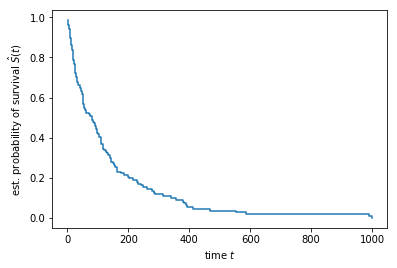

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
from sksurv.nonparametric import kaplan_meier_estimator

time, survival_prob = kaplan_meier_estimator(data_y["Status"], data_y["Survival_in_days"])
plt.step(time, survival_prob, where="post")
plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")

The estimated curve is a step function, with steps occuring at time points where one or more patients died. From the plot we can see that most patients died in the first 200 days, as indicated by the steep slope of the estimated survival function in the first 200 days.

估计的曲线是一个阶跃函数，阶跃发生在一个或多个病人死亡的时间点。从图中我们可以看到，大多数患者在前200天内死亡，正如前200天内估计生存功能的陡坡所示。


## Considering other variables by stratification

### Survival functions by treatment

Patients enrolled in the Veterans' Administration Lung Cancer Trial were randomized to one of two treatments: `standard` and a new `test` drug. Next, let's have a look at how many patients underwent the standard treatment and how many received the new drug.
## 通过分层来考虑其他变量
### 治疗的生存功能
参与退伍军人管理局肺癌试验的患者被随机分为两组:标准组和新型试验药物组。接下来，让我们看看有多少病人接受了标准治疗，又有多少人接受了新药。

In [49]:
data_x["Treatment"].value_counts()

standard    69
test        68
Name: Treatment, dtype: int64

Roughly half the patients received the alternative treatment.

The obvious questions to ask is:
> *Is there any difference in survival between the two treatment groups?*

As a first attempt, we can estimate the survival function in both treatment groups separately.

大约一半的病人接受了替代疗法。 最明显的问题是: 两个治疗组的存活率有什么不同吗? 作为第一次尝试，我们可以分别评估两个治疗组的生存功能。

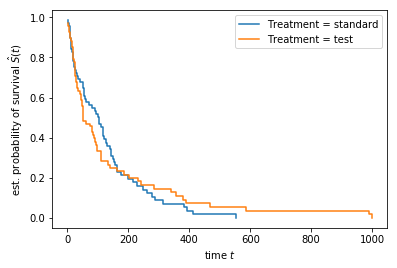

In [50]:
for treatment_type in ("standard", "test"):
    mask_treat = data_x["Treatment"] == treatment_type
    time_treatment, survival_prob_treatment = kaplan_meier_estimator(
        data_y["Status"][mask_treat],
        data_y["Survival_in_days"][mask_treat])
    
    plt.step(time_treatment, survival_prob_treatment, where="post",
             label="Treatment = %s" % treatment_type)

plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")
plt.legend(loc="best")

Unfortunately, the results are inconclusive, because the difference between the two estimated survival functions is too small to confidently argue that the drug affects survival or not.

*Sidenote: Visually comparing estimated survival curves in order to assess whether there is a difference in survival between groups is usually not recommended, because it is highly subjective. Statistical tests such as the [log-rank test](https://en.wikipedia.org/wiki/Log-rank_test) are usually more appropriate.*

不幸的是，结果是不确定的，因为这两个估计的生存功能的差异太小，不能自信地说药物影响生存与否。

旁注:通常不建议通过直观地比较估计的生存曲线来评估各组之间是否存在生存差异，因为这是非常主观的。统计检验，如log-rank检验通常更合适。

### Survival functions by cell type

Next, let's have a look at the cell type, which has been recorded as well, and repeat the analysis from above.

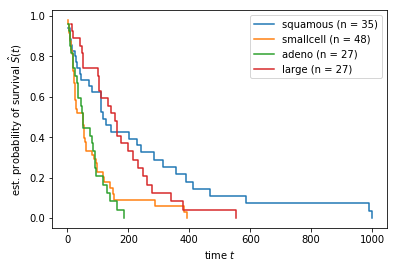

In [51]:
for value in data_x["Celltype"].unique():
    mask = data_x["Celltype"] == value
    time_cell, survival_prob_cell = kaplan_meier_estimator(data_y["Status"][mask],
                                                           data_y["Survival_in_days"][mask])
    plt.step(time_cell, survival_prob_cell, where="post",
             label="%s (n = %d)" % (value, mask.sum()))

plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")
plt.legend(loc="best")

In this case, we observe a pronounced difference between two groups. Patients with *squamous* or *large* cells seem to have a better prognosis compared to patients with *small* or *adeno* cells.

## Multivariate Survival Models

In the Kaplan-Meier approach used above, we estimated multiple survival curves by dividing the dataset into smaller sub-groups according to a variable. If we want to consider more than 1 or 2 variables, this approach quickly becomes infeasible, because subgroups will get very small. Instead, we can use a linear model, [Cox's proportional hazard's model](https://en.wikipedia.org/wiki/Proportional_hazards_model), to estimate the impact each variable has on survival.

First however, we need to convert the categorical variables in the data set into numeric values.

In [54]:
data_y.dtype.fields

mappingproxy({'Status': (dtype('bool'), 0),
              'Survival_in_days': (dtype('float64'), 1)})

In [7]:
from sksurv.preprocessing import OneHotEncoder

data_x_numeric = OneHotEncoder().fit_transform(data_x)
data_x_numeric.head()

,Age_in_years,Celltype=large,Celltype=smallcell,Celltype=squamous,Karnofsky_score,Months_from_Diagnosis,Prior_therapy=yes,Treatment=test
0,69.0,0.0,0.0,1.0,60.0,7.0,0.0,0.0
1,64.0,0.0,0.0,1.0,70.0,5.0,1.0,0.0
2,38.0,0.0,0.0,1.0,60.0,3.0,0.0,0.0
3,63.0,0.0,0.0,1.0,60.0,9.0,1.0,0.0
4,65.0,0.0,0.0,1.0,70.0,11.0,1.0,0.0


Survival models in **scikit-survival** follow the same rules as estimators in scikit-learn, i.e., they have a `fit` method, which expects a data matrix and a structered array of survival times and binary event indicators.

In [8]:
from sksurv.linear_model import CoxPHSurvivalAnalysis

estimator = CoxPHSurvivalAnalysis()
estimator.fit(data_x_numeric, data_y)

CoxPHSurvivalAnalysis(alpha=0, n_iter=100, tol=1e-09, verbose=0)

The result is a vector of coefficients, one for each variable, where each value corresponds to the [log hazard ratio](https://en.wikipedia.org/wiki/Hazard_ratio).

In [10]:
pd.Series(estimator.coef_, index=data_x_numeric.columns)

Age_in_years            -0.008549
Celltype=large          -0.788672
Celltype=smallcell      -0.331813
Celltype=squamous       -1.188299
Karnofsky_score         -0.032622
Months_from_Diagnosis   -0.000092
Prior_therapy=yes        0.072327
Treatment=test           0.289936
dtype: float64

Using the fitted model, we can predict a patient-specific survival function, by passing an appropriate data matrix to the estimator's `predict_survival_function` method .

First, let's create a set of four synthetic patients.

In [2]:
import pandas as pd
x_new = pd.DataFrame.from_dict({
    1: [65, 0, 0, 1, 60, 1, 0, 1],
    2: [65, 0, 0, 1, 60, 1, 0, 0],
    3: [65, 0, 1, 0, 60, 1, 0, 0],
    4: [65, 0, 1, 0, 60, 1, 0, 1]},
     columns=data_x_numeric.columns, orient='index')
x_new

NameError: name 'data_x_numeric' is not defined

Similar to `kaplan_meier_estimator`, the `predict_survival_function` method returns a sequence of step functions, which we can plot.

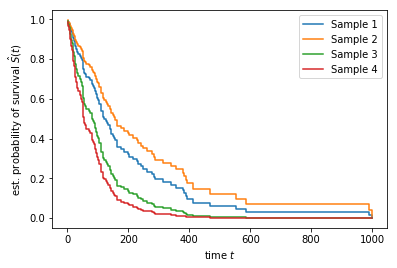

In [12]:
pred_surv = estimator.predict_survival_function(x_new)
for i, c in enumerate(pred_surv):
    plt.step(c.x, c.y, where="post", label="Sample %d" % (i + 1))
plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")
plt.legend(loc="best")

## Measuring the Performance of Survival Models

Once we fit a survival model, we usually want to assess how well a model can actually predict survival. Our test data is usually subject to censoring too, therefore metrics like root mean squared error or correlation are unsuitable. Instead, we use generalization of the area under the receiver operating characteristic (ROC) curve called [Harrell's concordance index](https://pdfs.semanticscholar.org/7705/392f1068c76669de750c6d0da8144da3304d.pdf) or c-index.

The interpretation is identical to the traditional area under the [ROC curve](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) metric for binary classification:
- a value of 0.5 denotes a random model,
- a value of 1.0 denotes a perfect model,
- a value of 0.0 denotes a perfectly wrong model.

In [13]:
from sksurv.metrics import concordance_index_censored

prediction = estimator.predict(data_x_numeric)
result = concordance_index_censored(data_y["Status"], data_y["Survival_in_days"], prediction)
result[0]

0.7362562471603816

or alternatively

In [14]:
estimator.score(data_x_numeric, data_y)

0.7362562471603816

Our model's c-index indicates that the model clearly performs better than random, but is also far from perfect.

## Feature Selection: Which Variable is Most Predictive?

The model above considered all available variables for prediction. Next, we want to investigate which single variable is the best risk predictor. Therefore, we fit a Cox model to each variable individually and record the c-index on the training set.

In [4]:
import numpy as np

def fit_and_score_features(X, y):
    n_features = X.shape[1]
    scores = np.empty(n_features)
    m = CoxPHSurvivalAnalysis()
    for j in range(n_features):
        Xj = X[:, j:j+1]
        m.fit(Xj, y)
        scores[j] = m.score(Xj, y)
    return scores

scores = fit_and_score_features(data_x_numeric.values, data_y)
pd.Series(scores, index=data_x_numeric.columns).sort_values(ascending=False)

NameError: name 'data_x_numeric' is not defined

`Karnofsky_score` is the best variable, whereas `Months_from_Diagnosis` and `Prior_therapy='yes'` have almost no predictive power on their own.

Next, we want to build a parsimonious model by excluding irrelevant features. We could use the ranking from above, but would need to determine what the optimal cut-off should be. Luckily, scikit-learn has built-in support for performing grid search.

First, we create a pipeline that puts all the parts together.

In [16]:
from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import Pipeline

pipe = Pipeline([('encode', OneHotEncoder()),
                 ('select', SelectKBest(fit_and_score_features, k=3)),
                 ('model', CoxPHSurvivalAnalysis())])

Next, we need to define the range of parameters we want to explore during grid search. Here, we want to optimize the parameter `k` of the `SelectKBest` class and allow `k` to vary from 1 feature to all 8 features.

In [17]:
from sklearn.model_selection import GridSearchCV

param_grid = {'select__k': np.arange(1, data_x_numeric.shape[1] + 1)}
gcv = GridSearchCV(pipe, param_grid, return_train_score=True, cv=3, iid=True)
gcv.fit(data_x, data_y)

pd.DataFrame(gcv.cv_results_).sort_values(by='mean_test_score', ascending=False)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_select__k,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
2,0.144138,0.009643,0.007307,0.000243,3,{'select__k': 3},0.650628,0.718220,0.754649,0.707491,0.043067,1,0.765569,0.695647,0.714082,0.725099,0.029590
4,0.144715,0.009725,0.007361,0.000250,5,{'select__k': 5},0.644874,0.738347,0.728822,0.703834,0.042098,2,0.783946,0.698207,0.718498,0.733551,0.036585
3,0.144993,0.010622,0.007718,0.000161,4,{'select__k': 4},0.650628,0.719809,0.725723,0.698523,0.034138,3,0.768121,0.691037,0.707327,0.722162,0.033172
1,0.151117,0.007475,0.007887,0.000234,2,{'select__k': 2},0.630753,0.717161,0.747934,0.698256,0.049604,4,0.758550,0.683611,0.705638,0.715933,0.031448
0,0.157661,0.025855,0.007474,0.000294,1,{'select__k': 1},0.630753,0.715042,0.737087,0.693982,0.045843,5,0.744640,0.676697,0.695246,0.705527,0.028675
5,0.145057,0.009781,0.007633,0.000454,6,{'select__k': 6},0.657427,0.669492,0.724690,0.683572,0.029179,6,0.783946,0.698848,0.716160,0.732985,0.036722
6,0.146337,0.010018,0.007295,0.000147,7,{'select__k': 7},0.654812,0.659958,0.714876,0.676269,0.027083,7,0.788412,0.695519,0.712133,0.732021,0.040447
7,0.146548,0.009896,0.007310,0.000097,8,{'select__k': 8},0.656904,0.653602,0.716942,0.675516,0.029004,8,0.786371,0.695006,0.713692,0.731690,0.039411


The results show that it is sufficient to select the 3 most predictive features.

In [18]:
pipe.set_params(**gcv.best_params_)
pipe.fit(data_x, data_y)

encoder, transformer, final_estimator = [s[1] for s in pipe.steps]
pd.Series(final_estimator.coef_, index=encoder.encoded_columns_[transformer.get_support()])

Celltype=large       -0.067277
Celltype=smallcell    0.271007
Karnofsky_score      -0.031285
dtype: float64

## What's next?

Cox's proportional hazards model is by far the most popular survival model, because once trained, it is easy to interpret. However, if prediction performance is the main objective, more sophisticated, non-linear or ensemble models might lead to better results. Check-out
[this notebook](https://nbviewer.jupyter.org/github/sebp/scikit-survival/blob/master/examples/evaluating-survival-models.ipynb) for getting a better understanding on how to evaluate survival models,
and [this notebook](https://nbviewer.jupyter.org/github/sebp/scikit-survival/blob/master/examples/survival-svm.ipynb) to learn more about Kernel Survival Support Vector Machines. The [API reference](https://scikit-survival.readthedocs.io/en/latest/api.html) contains a full list of models that are available within **scikit-survival**. In addition, you can use any unsupervised pre-processing method available with scikit-learn, for instance, you could perform dimensionality reduction using [Non-Negative Matrix Factorization (NMF)](http://scikit-learn.org/dev/modules/generated/sklearn.decomposition.NMF.html#sklearn.decomposition.NMF), before training a Cox model.